In [1]:
import sys
import os
import numpy as np
import pandas as pd

import subprocess

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display
from ipywidgets import IntProgress

In [2]:
print(sys.version)
mpl.rcParams['figure.facecolor'] = '#BBBBBB'


3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 09:07:38) 
[GCC 7.3.0]


In [3]:
GENOME = "AgamP4.11"
GENE_PREFIX = "AGAP"

TRANSFN = "../datafiles/transcript_list_{}".format(GENOME)
CHOPCHOP_OUT_DIR = "../all_transcripts_run/".format(GENOME)

MIN_GC = 30 # minimum allowable GC percentage (inclusive)
MAX_GC = 70 # maximum allowable GC percentage (inclusive)
MAX_OFFTARGET_HITS = 0 # maximum allowable total offtarget hits

In [4]:
tlist = pd.read_csv(TRANSFN, header=None, names=['transcript_id'])

In [5]:
t = tlist['transcript_id'].str.rsplit('-', n=1, expand=True)
t.columns = ['gene', 'splice_id']
tlist = pd.concat((tlist,t), axis=1)
tlist

,transcript_id,gene,splice_id
0,AGAP004677-RB,AGAP004677,RB
1,AGAP004677-RA,AGAP004677,RA
2,AGAP004678-RA,AGAP004678,RA
3,AGAP004679-RB,AGAP004679,RB
4,AGAP004679-RA,AGAP004679,RA
5,AGAP004680-RA,AGAP004680,RA
6,AGAP004681-RA,AGAP004681,RA
7,AGAP004682-RA,AGAP004682,RA
8,AGAP028431-RA,AGAP028431,RA
9,AGAP004683-RA,AGAP004683,RA


In [8]:
t['gene'].unique().shape

(13785,)

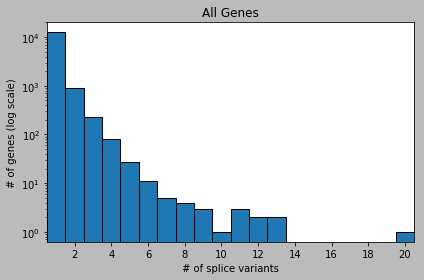

In [6]:
# histogram of number of splice variants by gene
t = tlist['gene'].value_counts()
fig,ax = plt.subplots()
ax.hist(t, bins=np.arange(t.min()-.5,t.max()+1.5), edgecolor='k');
ax.set_yscale('log')
ax.set_xlim((t.min()-.5, t.max()+.5))
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.set_title('All Genes')
ax.set_xlabel('# of splice variants')
ax.set_ylabel('# of genes (log scale)')
fig.tight_layout()

In [7]:
# use awk to append the transcript_ids and merge all the chopchop outputs
# stream than into pandas.read_csv
cmd = ("/usr/bin/awk -F "+r"'\t' "
"'BEGIN{OFS=FS}{if(FNR==1){if(NR==FNR){print $0, "+'"transcript_id"'+"}}else{print $0, FILENAME}}' "+
"{}/{}*".format(GENOME, GENE_PREFIX))

print(cmd)
with subprocess.Popen(cmd, cwd=CHOPCHOP_OUT_DIR, shell=True, stdout=subprocess.PIPE) as p:
    d_orig = pd.read_csv(p.stdout, sep='\t', index_col=0)

/usr/bin/awk -F '\t' 'BEGIN{OFS=FS}{if(FNR==1){if(NR==FNR){print $0, "transcript_id"}}else{print $0, FILENAME}}' AgamP4.11/AGAP*


/home/travc/miniconda3/envs/allel/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
d = d_orig.copy(deep=True) # so we don't munge the original data
d.reset_index(inplace=True)

# set the >=555 sort of entries in the MM columns to 999
d["sumMM"] = d.loc[:,("MM0","MM1","MM2","MM3")].\
    apply(pd.to_numeric, errors='coerce').fillna(999).sum(axis=1)

# filter
flt = ((d["GC content (%)"] >= MIN_GC) & 
      (d["GC content (%)"] <= MAX_GC) &
      (d["sumMM"] <= MAX_OFFTARGET_HITS))
if True: # apply filter
    d = d.loc[flt,:]
else:
    d['flt'] = flt

# add a gene column
d['gene'] = d['transcript_id'].str.rsplit('-',1).str.get(0)

print("{} of {} unique transcript_ids left after flitering".format( 
      d['transcript_id'].unique().shape[0],
      d_orig['transcript_id'].unique().shape[0]))

14789 of 15712 unique transcript_ids left after flitering


In [9]:
# unique target+gene
t = d.set_index('Genomic location').loc[:,('Target sequence','gene')]

single_target_different_genes = t[t.index.duplicated() & ~t.duplicated()]
print(single_target_different_genes.shape[0], "targets hitting more than one gene")
print(single_target_different_genes['gene'].unique().shape[0], "genes affected")

# filter to targets which are unique or hit different genes
t = t[~t.duplicated(keep='first')]
print(t.shape[0], 'unique target+gene combinations')

# number of genes with 0 targets
total_num_genes = tlist['gene'].unique().shape[0]
num_0_target_genes =total_num_genes - t['gene'].unique().shape[0]
print(num_0_target_genes, "genes of", total_num_genes, "with no targets")

2012 targets hitting more than one gene
259 genes affected
1204754 unique target+gene combinations
920 genes of 13785 with no targets


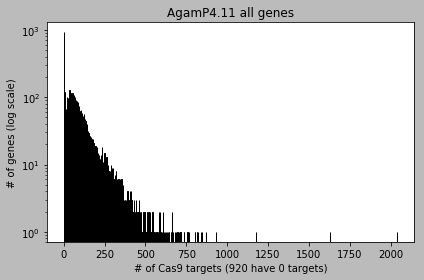

In [10]:
cnt = t['gene'].value_counts().values
# add entries for genes with 0 targets
cnt = np.append(cnt, [0]*num_0_target_genes)

# histogram of number of splice variants by gene
fig,ax = plt.subplots()
ax.hist(cnt, edgecolor='k', bins=cnt.max()+1, align='mid')#, bins=np.arange(cnt.min()-.5,cnt.max()+1.5));
ax.set_yscale('log')
# ax.set_xlim((-1,10))
# ax.set_xlim((cnt.min()-.5, cnt.max()+.5))
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.set_title('{} all genes'.format(GENOME))
ax.set_xlabel('# of Cas9 targets ({} have 0 targets)'.format(num_0_target_genes))
ax.set_ylabel('# of genes (log scale)')
fig.tight_layout()

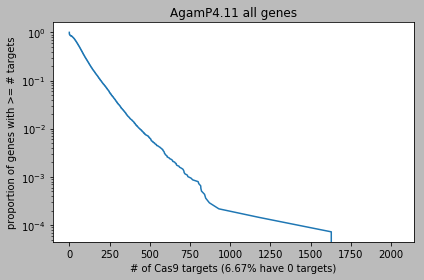

In [14]:
cnt = t['gene'].value_counts().values
# add entries for genes with 0 targets
cnt = np.append(cnt, [0]*num_0_target_genes)

fig,ax = plt.subplots()

# inverse emperical cdf
x = np.sort(cnt)
y = np.arange(1,len(x)+1)/float(len(x))
plt.plot(x, 1-y)

ax.set_yscale('log')
ax.set_title('AgamP4.11 all genes')
ax.set_xlabel('# of Cas9 targets ({:.2f}% have 0 targets)'.format(
    100*num_0_target_genes/total_num_genes))
ax.set_ylabel('proportion of genes with >= # targets')
fig.tight_layout()

In [12]:
cnt = t['gene'].value_counts().values
cnt = np.append(cnt, [0]*num_0_target_genes)
cnt = pd.Series(cnt)
cnt.describe()

count    13785.000000
mean        87.396010
std         94.070914
min          0.000000
25%         29.000000
50%         63.000000
75%        114.000000
max       2042.000000
dtype: float64